In [3]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
import cx_Oracle
import matplotlib.pyplot as plt
import time 
import os
import pickle

os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\VMM Value Add")
seed = 5

# Read Data

In [214]:
# # @in the password is causing errror in using the below syntax
# # connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# connection = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# cursor = connection.cursor()

# query= """
# with uw_base as 
# (
# select a.skp_credit_case, time_decision_date, client_exi_3m, product_group, flag_1pct_phantom, 
# risk_fpd30, risk_agrf30, 
# risk_fstpd30, risk_agrf90,
# risk_fstqpd30, risk_agrf120, 
# risk_fstqpd60, risk_agrf150, pos_type,
# case when score_cb < 300 then 'NTC' else 'Others' end as NTC_FLAG,
# case when time_decision_date >= to_date('15-10-20','dd-mm-yy') then nvl(POS_AUG20_GM,GM_SCORE) else GM_SCORE end as RISK_SCORE
# from uw_daily_data_all a
# left join 
# (select skp_credit_case, score_cb_linear_lgbm, 
# 1/(1+exp(-1*score_cb_linear_lgbm)) as GM_SCORE
# from pos_rescored_new) b
# on a.skp_credit_case = b.skp_credit_case
# where time_decision_date >= to_date('18-06-20','dd-mm-yy')
# and product_group = 'CD'
# and client_exi_3m = 'N'
# and decision_overall = 'Approved'
# ),

# bd_source_base as 
# (
# select skp_credit_case, result, 1 as score1 from bd_vmm
# where date_decision >= to_date('18-06-20','dd-mm-yy')
# )

# select a.skp_credit_case, time_decision_date, client_exi_3m, 
# product_group, flag_1pct_phantom, NTC_FLAG,
# risk_fpd30, risk_agrf30, 
# risk_fstpd30, risk_agrf90,
# risk_fstqpd30, risk_agrf120, 
# risk_fstqpd60, risk_agrf150,
# case when result = 'FOUND' then 'FOUND' else 'NOT_FOUND' end as result, 
# pos_type, score1, RISK_SCORE
# from 
# uw_base a 
# join bd_source_base b 
# on a.skp_credit_case = b.skp_credit_case
# where risk_score is not null
# and result in ('FOUND','NOT_FOUND')
# order by skp_credit_case
# """

# df = pd.read_sql(query,connection)

# df.to_pickle(os.getcwd()+r"\Data Files\loan_performance_dump_new_clients.pkl")

In [2]:
df = pd.read_pickle(os.getcwd()+r"\Data Files\loan_performance_dump_new_clients.pkl")
# df = pd.read_csv(os.getcwd()+r"\Data Files\loan_performance_dump_v1.csv")
df = df[df["NTC_FLAG"]=="NTC"]

# Define Key Variables

In [216]:
time_decision_date = 'TIME_DECISION_DATE'
source = 'VMM'
target_variable = "RISK_FPD30"
agrf_flag = "RISK_AGRF30"
fnf_flag = 'RESULT'
score = ['SCORE1']
risk_score = 'RISK_SCORE'

# Data Cleaning

In [217]:
#One Hot Encoding of fnf_flag
dummy = pd.get_dummies(df[fnf_flag])
dummy.columns = [y+"_"+fnf_flag for y in dummy.columns]
df = pd.concat([df, dummy], axis=1)

In [218]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CLIENT_EXI_3M,PRODUCT_GROUP,FLAG_1PCT_PHANTOM,NTC_FLAG,...,RESULT,POS_TYPE,SCORE1,RISK_SCORE,FOUND_RESULT,NOT_FOUND_RESULT
1,308216769,2020-06-18,N,CD,1,NTC,...,NOT_FOUND,AP,1,0.039359,0,1
2,308216861,2020-06-18,N,CD,1,NTC,...,NOT_FOUND,Satellite,1,0.030472,0,1
7,308219481,2020-06-18,N,CD,1,NTC,...,NOT_FOUND,AP,1,0.030472,0,1
8,308224751,2020-06-18,N,CD,1,NTC,...,NOT_FOUND,UDAAN,1,0.030472,0,1
10,308225310,2020-06-18,N,CD,1,NTC,...,NOT_FOUND,Satellite,1,0.042783,0,1


In [219]:
df.TIME_DECISION_DATE = pd.to_datetime(df.TIME_DECISION_DATE,format = '%d-%m-%y')
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

In [220]:
df = df[df.CLIENT_EXI_3M == 'N']

In [221]:
df = df[df[agrf_flag]==1]

<AxesSubplot:>

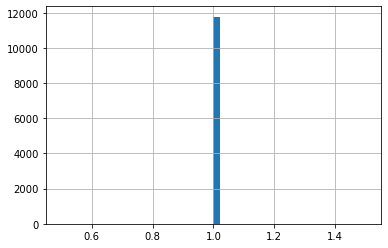

In [222]:
df[df["RESULT"]=="FOUND"]["SCORE1"].hist(bins = 50)

In [223]:
2*roc_auc_score(df["RISK_FPD30"],df["RISK_SCORE"])-1

0.2060983194612649

# MOM Plot of delinquency

In [224]:
df_agg=df[["MONTH_STR",target_variable]].groupby(["MONTH_STR"]).agg(["count","sum"])
df_agg.columns = ['_'.join(x) for x in df_agg.columns]
df_agg["BAD_RATE"] = df_agg[target_variable+"_sum"]/df_agg[target_variable+"_count"]

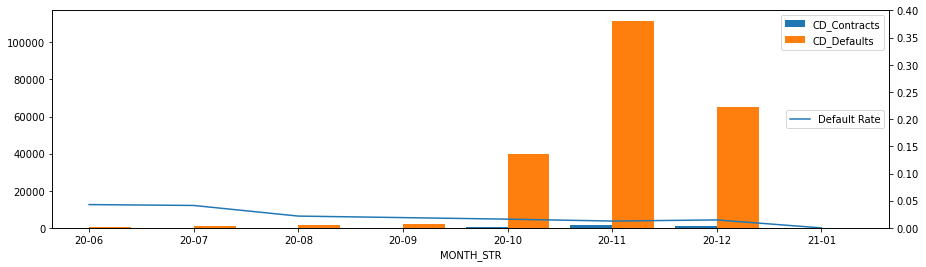

In [225]:
df_agg[[target_variable+"_sum",target_variable+"_count"]].plot(kind='bar', width = 0.8, figsize=(15,4))
df_agg['BAD_RATE'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_agg[target_variable+"_sum"])-0.35])
ax.set_xticklabels(df_agg.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.4)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")
plt.show()

# Define Key Variables

In [226]:
train_start = pd.datetime(2020,6,1)
train_end = pd.datetime(2020,10,31)
test_start = pd.datetime(2020,11,1)
test_end = pd.datetime(2020,12,31)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The

# Logistic Model- FNF Only

In [227]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)- np.log(1 -p)

## Test Train Split

In [228]:
for x in ["SCORE1","RISK_SCORE"]:
    df["LOG_"+x] = logit(df[x])
    df["LOG_"+x] = df["LOG_"+x].fillna(value = 0)

x_columns=['FOUND_RESULT','LOG_RISK_SCORE']
y_column = target_variable 

X_train_all = df[(df.TIME_DECISION_DATE>=train_start) & (df.TIME_DECISION_DATE<=train_end)]
y_train_all = df[(df.TIME_DECISION_DATE>=train_start) & (df.TIME_DECISION_DATE<=train_end)][y_column]

X_test = df[(df.TIME_DECISION_DATE>=test_start) & (df.TIME_DECISION_DATE<=test_end)]
y_test = df[(df.TIME_DECISION_DATE>=test_start) & (df.TIME_DECISION_DATE<=test_end)][y_column]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size = 0.7, random_state = seed)

##event rate
print("Event rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("Train set shape:",X_train.shape)
print("Event rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("Test set shape:",X_test.shape)
print("Event rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("validation set shape:",X_valid.shape)
print("Train GINI",  roc_auc_score(y_train, X_train[risk_score])*2 -1)
print("Test GINI",  roc_auc_score(y_test, X_test[risk_score])*2 -1)
print("validation GINI",  roc_auc_score(y_valid, X_valid[risk_score])*2 -1)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Event rate in train set : 1.66%
Train set shape: (13409, 23)
Event rate in test set : 1.33%
Test set shape: (176941, 23)
Event rate in validation set : 1.77%
validation set shape: (31289, 23)
Train GINI 0.17657063296708397
Test GINI 0.20426912210853487
validation GINI 0.224647469099867


## L1 Penalty Hyper Parameter Optimization

In [229]:
param_grid = {'C':np.exp(np.arange(-6,3,0.01))}

In [230]:
kfolds = StratifiedKFold(3, random_state=1, shuffle = True)
comb=LogisticRegression(penalty = 'l1', solver = 'liblinear')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 40,
    cv=kfolds.split(X_train[x_columns],y_train), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [231]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train[x_columns], y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 

Randomized search..
Randomized search time: 3.721817970275879


{'C': 16.444646771093964}


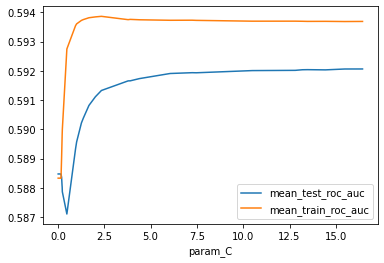

In [232]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
print(params)

## Logistic With optimized Hyperparameters 

In [233]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=params['C'], solver='liblinear')

bst.fit(X_train[x_columns], y_train)

ypred_train = bst.predict_proba(X_train[x_columns])[:, 1]
ypred_valid = bst.predict_proba(X_valid[x_columns])[:, 1]
ypred_test = bst.predict_proba(X_test[x_columns])[:, 1]

print("Train GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_train, ypred_train)-1))
print("Valid GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_valid, ypred_valid)-1))
print("Test GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(y_test, ypred_test)-1))

print("Train GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_train, X_train[risk_score])-1))
print("Valid GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_valid, X_valid[risk_score])-1))
print("Test GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(y_test, X_test[risk_score])-1))


Train GINI(COMBINED_SCORE) 0.186
Valid GINI(COMBINED_SCORE) 0.223
Test GINI(COMBINED_SCORE) 0.203
Train GINI(RISK_SCORE) 0.177
Valid GINI(RISK_SCORE) 0.225
Test GINI(RISK_SCORE) 0.204


In [234]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,FOUND_RESULT,-0.598295
1,LOG_RISK_SCORE,0.473917


In [235]:
df["COMBINED_SCORE_ONLY_FNF_FLAG"] =  bst.predict_proba(df[x_columns])[:, 1]

## Model Evaluation

In [236]:
combined_score_only_fnf_flag = "COMBINED_SCORE_ONLY_FNF_FLAG"

### Gini Chart

In [237]:
print("GINI(RISK_SCORE) %.3f" % (2*roc_auc_score(df[target_variable], df[combined_score_only_fnf_flag])-1))

GINI(RISK_SCORE) 0.206


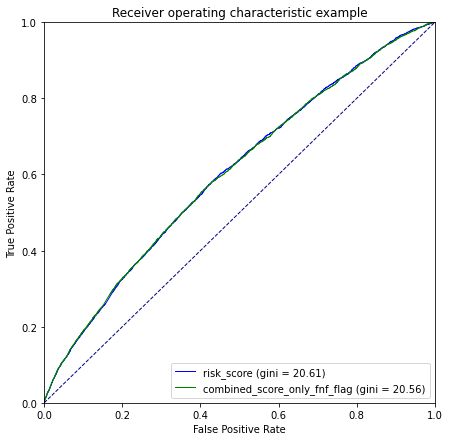

In [238]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1


fpr, tpr, thresholds = roc_curve(df[target_variable],df[risk_score])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='risk_score (gini = %0.2f)' % ((2*roc_auc-1)*100))



fpr, tpr, thresholds = roc_curve(df[target_variable],df[combined_score_only_fnf_flag])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='combined_score_only_fnf_flag (gini = %0.2f)' % ((2*roc_auc-1)*100))


ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [239]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CLIENT_EXI_3M,PRODUCT_GROUP,FLAG_1PCT_PHANTOM,NTC_FLAG,...,FOUND_RESULT,NOT_FOUND_RESULT,MONTH_STR,LOG_SCORE1,LOG_RISK_SCORE,COMBINED_SCORE_ONLY_FNF_FLAG
1,308216769,2020-06-18,N,CD,1,NTC,...,0,1,20-06,inf,-3.194882,0.024188
2,308216861,2020-06-18,N,CD,1,NTC,...,0,1,20-06,inf,-3.460000,0.021393
8,308224751,2020-06-18,N,CD,1,NTC,...,0,1,20-06,inf,-3.460000,0.021393
10,308225310,2020-06-18,N,CD,1,NTC,...,0,1,20-06,inf,-3.107880,0.025180
12,308227027,2020-06-18,N,CD,1,NTC,...,0,1,20-06,inf,-3.460000,0.021393


In [240]:
gini_dic = {}
predictor_list = ["FOUND_RESULT"]
for x in df["MONTH_STR"].unique():
    try:
        if "MONTH_STR" not in gini_dic:
            gini_dic["MONTH_STR"] = []
        if risk_score not in gini_dic: 
            gini_dic[risk_score] = []
        if combined_score_only_fnf_flag not in gini_dic: 
            gini_dic[combined_score_only_fnf_flag] = []
        
        gini_dic[risk_score].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic[combined_score_only_fnf_flag].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][combined_score_only_fnf_flag])-1)*100)
        gini_dic["MONTH_STR"].append(x)
        for y in predictor_list:
            if y not in gini_dic:
                  gini_dic[y] = []
            if y != 'FOUND_RESULT':
                try:
                    gini_dic[y].append(((2*roc_auc_score(df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][target_variable],df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][y])-1)*100))
                except:
                    gini_dic[y].append(0)
            else:
                gini_dic[y].append(((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH_STR",inplace = True)
gini_df.reset_index(inplace = True)


ERROR


Found Rate:  5.31%


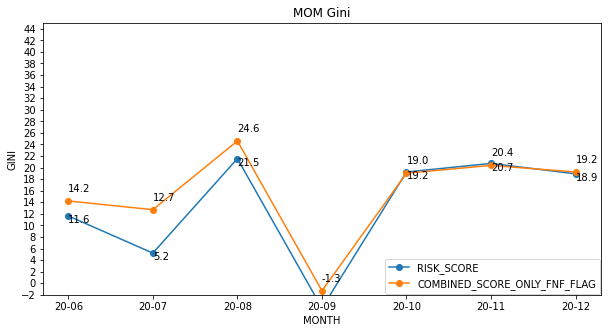

In [241]:
print("Found Rate: ","{:,.2%}".format(df["FOUND_RESULT"].sum()/df["FOUND_RESULT"].count()))
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH_STR"],gini_df[risk_score], marker='o', scaley = False, label = risk_score)
ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df[risk_score]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[risk_score][i]-1.2))
for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(-2,45,2))
ax1.set_title("MOM Gini")
plt.show()


GINI of BD Source score is corresponding to found cases only!
Found Rate:  5.31%


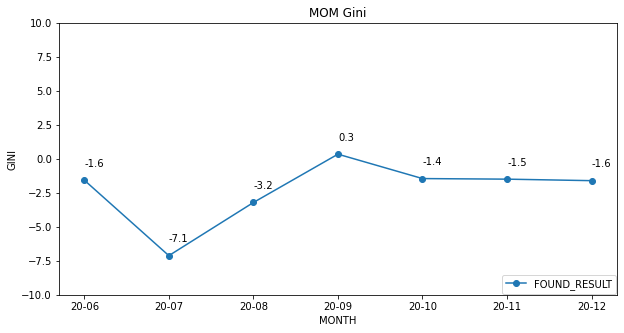

In [242]:
print("GINI of BD Source score is corresponding to found cases only!")
print("Found Rate: ","{:,.2%}".format(df["FOUND_RESULT"].sum()/df["FOUND_RESULT"].count()))
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score], marker='o', scaley = False, label = combined_score)
# ax1.plot(gini_df["MONTH_STR"],gini_df[risk_score], marker='o', scaley = False, label = risk_score)
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
for y in predictor_list:
    ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


# for i, txt in enumerate(gini_df[combined_score]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score][i]+0.8))
# for i, txt in enumerate(gini_df[risk_score]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[risk_score][i]-1.2))
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

for y in predictor_list:
    for i, txt in enumerate(gini_df[y]):
        plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-10,10)
plt.ylabel("GINI")
plt.xlabel("MONTH")
# plt.yticks(np.arange(-50,50,2))
ax1.set_title("MOM Gini")
plt.show()


## Lifts and Gains Chart

In [243]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [244]:
def lift_and_gain_df(data=None,target=None, prob=None, bucket = 10):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob]+jitter(data[prob]), bucket)
    grouped = data.groupby('bucket', as_index = False)
    liftstable = pd.DataFrame()
    liftstable['min_prob'] = grouped.agg(['min'])[prob].iloc[:,0]
    liftstable['max_prob'] = grouped.agg(['max'])[prob].iloc[:,0]
    liftstable['total']   = grouped.agg(['count'])[target].iloc[:,0]
    liftstable['bads']   = round(grouped.agg(['sum'])[target].iloc[:,0])
    liftstable['goods'] = round(grouped.agg(['sum'])['target0'].iloc[:,0])
    liftstable['%base'] = (liftstable.total / data[target].count())
    liftstable = liftstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    liftstable['cum%_base'] = (liftstable.total / data[target].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data[target].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data[target].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()

    
    liftstable['lift'] = np.round(liftstable['%bads']/liftstable['%base'] , 3)
    liftstable['cum_lift'] = np.round(liftstable['cum%_bads']/liftstable['cum%_base'] , 3)

    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)

    liftstable.index = range(1,11)
    liftstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 13)
    return(liftstable)

In [245]:
#cum%_bads is gain_score
risk_score_lift = lift_and_gain_df(data=df,target=target_variable, prob=risk_score)
combined_score_only_fnf_flag_lift = lift_and_gain_df(data=df,target=target_variable, prob=combined_score_only_fnf_flag)

### Cumulative Lift Chart 

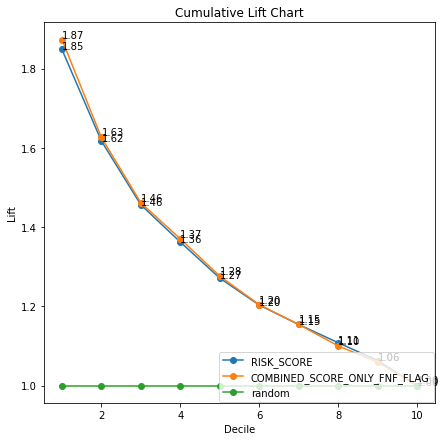

In [246]:
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(1,1,1)


ax1.plot(risk_score_lift.index,risk_score_lift["cum_lift"], label = risk_score, marker='o')
for i, txt in enumerate(risk_score_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (risk_score_lift.index[i], risk_score_lift["cum_lift"][i+1]))
    
ax1.plot(combined_score_only_fnf_flag_lift.index,combined_score_only_fnf_flag_lift["cum_lift"], label = combined_score_only_fnf_flag, marker='o')
for i, txt in enumerate(combined_score_only_fnf_flag_lift["cum_lift"]):
    plt.annotate("{:.2f}".format(txt), (combined_score_only_fnf_flag_lift.index[i], combined_score_only_fnf_flag_lift["cum_lift"][i+1]+0.005))



ax1.plot(np.arange(1,11,1),[1,1,1,1,1,1,1,1,1,1], label = 'random', marker='o')

plt.legend(loc='lower right', borderaxespad=0.1)
plt.xlabel("Decile")
plt.ylabel("Lift")

ax1.set_title("Cumulative Lift Chart")
plt.show()    


# Archieve

# MOM Gini: FSTPD30 Target

In [247]:
df = pd.read_pickle(os.getcwd()+r"\Data Files\loan_performance_dump_new_clients.pkl")
df = df[df["NTC_FLAG"]=="NTC"]

In [248]:
time_decision_date = 'TIME_DECISION_DATE'
source = 'VMM'
target_variable = "RISK_FSTPD30"
agrf_flag = "RISK_AGRF90"
fnf_flag = 'RESULT'
score = ['SCORE1']
risk_score = 'RISK_SCORE'

In [249]:
#One Hot Encoding of fnf_flag
dummy = pd.get_dummies(df[fnf_flag])
dummy.columns = [y+"_"+fnf_flag for y in dummy.columns]
df = pd.concat([df, dummy], axis=1)

In [250]:
df.TIME_DECISION_DATE = pd.to_datetime(df.TIME_DECISION_DATE,format = '%d-%m-%y')
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

df = df[df.CLIENT_EXI_3M == 'N']

df = df[df[agrf_flag]==1]

In [251]:
for x in ["SCORE1","RISK_SCORE"]:
    df["LOG_"+x] = logit(df[x])
    df["LOG_"+x] = df["LOG_"+x].fillna(value = 0)

x_columns=['FOUND_RESULT','LOG_RISK_SCORE']

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [252]:
df["COMBINED_SCORE_ONLY_FNF_FLAG"] =  bst.predict_proba(df[x_columns])[:, 1]

In [253]:
gini_dic = {}
predictor_list = ["FOUND_RESULT"]
for x in df["MONTH_STR"].unique():
    try:
        if "MONTH_STR" not in gini_dic:
            gini_dic["MONTH_STR"] = []
        if risk_score not in gini_dic: 
            gini_dic[risk_score] = []
        if combined_score_only_fnf_flag not in gini_dic: 
            gini_dic[combined_score_only_fnf_flag] = []
        
        gini_dic[risk_score].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][risk_score])-1)*100)
        gini_dic[combined_score_only_fnf_flag].append((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][combined_score_only_fnf_flag])-1)*100)
        gini_dic["MONTH_STR"].append(x)
        for y in predictor_list:
            if y not in gini_dic:
                  gini_dic[y] = []
            if y != 'FOUND_RESULT':
                try:
                    gini_dic[y].append(((2*roc_auc_score(df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][target_variable],df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][y])-1)*100))
                except:
                    gini_dic[y].append(0)
            else:
                gini_dic[y].append(((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH_STR",inplace = True)
gini_df.reset_index(inplace = True)


ERROR


Found Rate:  5.61%


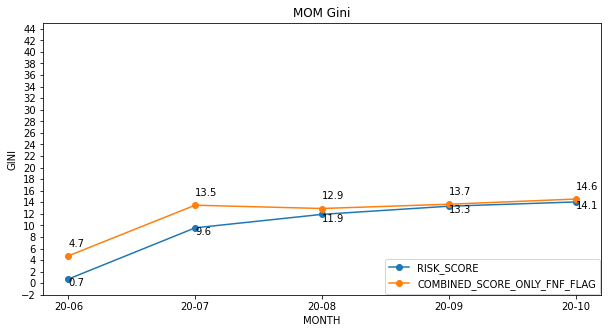

In [254]:
print("Found Rate: ","{:,.2%}".format(df["FOUND_RESULT"].sum()/df["FOUND_RESULT"].count()))
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH_STR"],gini_df[risk_score], marker='o', scaley = False, label = risk_score)
ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df[risk_score]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[risk_score][i]-1.2))
for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(-2,45)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(-2,45,2))
ax1.set_title("MOM Gini")
plt.show()
